In [111]:
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm import tqdm

from reconstruct import get_SIFT_keypoints, get_X
from utils import read, compute_F
from stereo import Stereo

In [59]:
def select_X(candidates):
    pd = pairwise_distances(candidates)
    
    ratings = np.sum(1/(pd.mean()/2+pd), axis=1)
    return candidates[np.argmax(ratings)]

In [99]:
images_number = [i for i in range(21)]
n_images = len(images_number)

In [100]:
images, P, silhouettes = zip(*[read(number) for number in images_number])

In [101]:
P = np.array(P)
silhouettes = np.array(silhouettes)

In [102]:
F = np.zeros((n_images, n_images, 3, 3))

In [103]:
for i in range(n_images):
    for j in range(i+1, n_images):
        f = compute_F(P[i], P[j])
        F[i,j] = f
        F[j,i] = f

In [104]:
n_keypoints = 20

In [105]:
kps = get_SIFT_keypoints(images[0], silhouettes[0])[:n_keypoints]

In [106]:
KP = np.zeros((n_images, n_keypoints, 3))

In [107]:
for i, (image, silhouette) in enumerate(zip(images, silhouettes)):
    KP[i] = get_SIFT_keypoints(image, silhouette)[:n_keypoints]

In [108]:
X_candidates = np.zeros((n_images, n_keypoints, n_images, 3))

In [109]:
stereo = Stereo(silhouettes.shape[2], silhouettes.shape[1])

In [112]:
for i in tqdm(range(n_images)):
    for ik, x1 in enumerate(KP[i]):
        for j in range(n_images):
            if j != i:
                x2 = stereo.find_x2(x1, F[i,j], images[i], images[j], kernel_size=[20,20])
                if x2 is not None:
                    X = get_X(P[i], P[j], x1, x2)
                    X_candidates[i][ik][j] = X[:-1]

 10%|▉         | 2/21 [00:06<00:55,  2.92s/it]/Users/quentinblampey/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
 19%|█▉        | 4/21 [00:23<01:39,  5.84s/it]/Users/quentinblampey/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
 24%|██▍       | 5/21 [00:33<01:53,  7.08s/it]/Users/quentinblampey/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/quentinblampey/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
 29%|██▊       | 6/21 [00:43<01:56,  7.76s/it]/Users/quentinblampey/opt/anaconda3/lib/pyth

In [113]:
X_candidates.resize((n_images*n_keypoints, n_images, 3))

In [115]:
X_list = []

for candidates in X_candidates:
    candidates = np.array([c for c in candidates if np.sum(c) != 0])
    if len(candidates) > 0:
        X_list.append(select_X(candidates))
    
X_list = np.array(X_list)

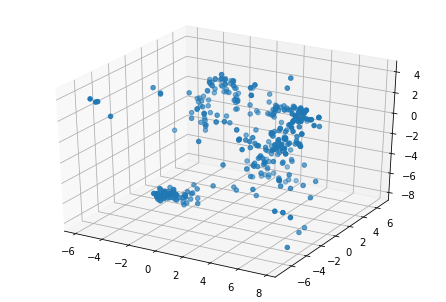

In [116]:
%matplotlib inline 
#%matplotlib notebook 
fig = plt.figure()
ax = Axes3D(fig)

X_list = np.array(X_list)
ax.scatter(X_list[:,0], X_list[:,1], X_list[:,2])